<font color='blue' size="+2"><b>Imports </b></font>

In [150]:
from scipy.stats import norm
from copy import deepcopy
import numpy as np
import mathgh
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
# makes sure that the outputted plot will appear immediately under each code cell
%matplotlib inline


<font color='blue' size="+2"><b>Upload the dataset </b></font>

In [151]:
# dataset for movies
movies = pd.read_csv('movies.csv')
movies['released'] = pd.to_datetime(movies.released)

# get columns
columns = movies.columns
    

<font color='green' size="+1.75"><b>Data Preprocessing </b></font><br>


<font color='blue' size="+1"><b>Clean the data </b></font><br>
### For clustering the data must either be an integer or float 
### Since K-Means uses Euclidean distance, having categorical data is not a good idea

<font color='black' size="+0"><i><b>Check for NULL values in the whole document as well as columnwise distribution </i></b></font><br>

In [152]:
# feature engineering
movies.pop('released')
movies.pop('writer')
movies.pop('star')
movies.pop('runtime')
movies.pop('year')

movies_names = movies.pop('name')


           


# get a copy of the dataset with categorical columns
movies_cat = movies.select_dtypes(include=['object']).copy()

# get the number of null values
print(movies.isnull().values.sum())

# columnwise distribution of null values
print(movies.isnull().sum())

# int/float = budget, gross, runtime, score, votes, year
# text = company-2179, country-57, director-2759, genre-17,name-6731, rating-13, released-2403, star-2504, writer-4199, 

# Frequency distribution of categories within the feature
#print(movies_cat['writer'].value_counts())

# count of distinct categories in a feature
#print(movies_cat['writer'].value_counts().count())

# Remove the name column because each value is different and they cannot be classified into clusters




0
budget      0
company     0
country     0
director    0
genre       0
gross       0
rating      0
score       0
votes       0
dtype: int64


In [37]:
# %matplotlib inline
# from ast import literal_eval
# # plot of frequency distribution of each categorical feature

# # int/float = budget, gross, runtime, score, votes, year
# # text = company-2179, country-57, director-2759, genre-17,name-6731, rating-13, released-2403, star-2504, writer-4199, 


# company_count = movies['company'].value_counts()
# print(company_count.index)
# sns.set(style="darkgrid")
# sns.barplot(company_count.index,company_count.values, alpha=0.9)
# plt.title('Frequency Distribution of Companies')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Company', fontsize=12)
# plt.show()

<font color='black' size="+2"><b>Categorical Data to Numeric </b></font><br>


In [38]:
# Transform the categorical data to dummies
# int/float = budget, gross, runtime, score, votes, year
# text = company, country, director, genre,name, rating, released, star, writer,

# LABEL ENCODING 
## DISADVANTAGE : Numerical values can be misinterpreted US => 1, China => 56

def label_encoding(df,col):
    df[str(col)] = df[str(col)].astype('category')
    df[str(col)] = df[str(col)].cat.codes
    df.head()
    return df

# ONE-HOT ENCODING
## Advantage => Weighing a value properly
## Disadvantage => "Curse of Dimensionality"

def one_hot(df,cols):
    movies_onehot = df.copy()
    for j in cols:
        movies_onehot[j] = movies_onehot[j].astype('category')
    movies_onehot = pd.get_dummies(movies_onehot, columns=cols)
    movies_onehot.head()
    return movies_onehot


In [39]:
# Retrieve the names of all categorical columns and store it in a list for one-hot encoding

cat_col_indexed = movies_cat.columns
cat_col = []
for i in cat_col_indexed:
    cat_col.append(i)
print(cat_col)

for i in cat_col:
    temp = label_encoding(movies,i)
#temp = one_hot(movies,cat_col)
temp.columns
    

['company', 'country', 'director', 'genre', 'rating']


Index([u'budget', u'company', u'country', u'director', u'genre', u'gross',
       u'rating', u'score', u'votes'],
      dtype='object')

In [40]:
# convert a pandas dataframe to numpy array

movies_arr = temp.values
print(movies_arr.shape)



(6820L, 9L)


### Correlation

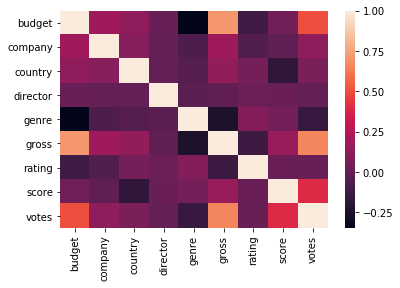

In [41]:
import seaborn as sns
corr = temp.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [42]:
corr = temp.corr()
corr.style.background_gradient()

,budget,company,country,director,genre,gross,rating,score,votes
budget,1,0.187205,0.137635,0.0116018,-0.346794,0.712196,-0.11966,0.0421447,0.503924
company,0.187205,1,0.10795,0.00431963,-0.0683303,0.18722,-0.06225,-0.0104262,0.138662
country,0.137635,0.10795,1,0.00369835,-0.0427926,0.149988,0.057979,-0.174414,0.0786571
director,0.0116018,0.00431963,0.00369835,1,-0.0276685,-0.0114292,0.0219256,0.0171302,0.000639015
genre,-0.346794,-0.0683303,-0.0427926,-0.0276685,1,-0.242676,0.10096,0.0562342,-0.150519
gross,0.712196,0.18722,0.149988,-0.0114292,-0.242676,1,-0.135538,0.165693,0.662457
rating,-0.11966,-0.06225,0.057979,0.0219256,0.10096,-0.135538,1,0.0192708,0.0116783
score,0.0421447,-0.0104262,-0.174414,0.0171302,0.0562342,0.165693,0.0192708,1,0.393607
votes,0.503924,0.138662,0.0786571,0.000639015,-0.150519,0.662457,0.0116783,0.393607,1


<font color='blue' size="+2"><b>Standardization </b></font>

In [43]:
# Arranging data so that each sample is a column in the data matrix
X = movies_arr.T # Data matrix

# Computation of the empirical mean of data, both as a vector and as a tiled matrix
mean_vec = X.mean(axis = 1)
mean_mat = np.tile(mean_vec.reshape(X.shape[0],1),[1,X.shape[1]])

# Centered data matrix
centered_X = X - mean_mat




<font color='blue' size="+1"><b>Principal Component Analysis</b></font>

In [44]:
# Singular value decomposition of centered data
U, s, Vh = np.linalg.svd(centered_X)

print(s)


[5.36108e+09 1.92382e+09 8.05855e+06 6.60058e+04 5.23250e+04 1.16193e+03
 2.01393e+02 1.05810e+02 7.27609e+01]


In [90]:
# Matrix of the top 2 principal components of the centered data matrix
U_2 = U[:,0:2]

# For gmm lets print only the top feature
UGMM = U[:,0:1]

# Compute the PCA-based features of the centered data using the top-two principal components
X_tilde = np.matmul(U_2.T,centered_X)

X_tilde_GMM = np.matmul(UGMM.T,centered_X)


(2L, 6820L)


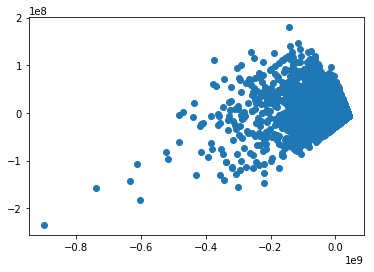

In [46]:
print(X_tilde.shape)
x = X_tilde[0,:]
y = X_tilde[1,:]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
plt.show()



In [47]:
# Create a trace
import plotly
init_notebook_mode(connected=True)

#py.tools.set_credentials_file(username='manviagarwal', api_key='Pesu@123')

trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers'
)

data = [trace]

# Plot and embed in ipython notebook!
plotly.offline.plot(data,filename='basic-scatter.html',auto_open=True)

# or plot with: plot_url = py.plot(data, filename='basic-line')

'file://C:\\Users\\maanv\\OneDrive\\Desktop\\Fall 2018\\ML\\Datasets\\basic-scatter.html'

In [48]:
data = X_tilde.T
print(data.shape)

(6820L, 2L)


### Removing the special characters from the data

In [72]:
import re
name_m = list(movies_names)
new = []
#print(name_m)
for i in name_m:
    try:
        dec = i.encode('utf-8').strip()
        new.append(dec)
    except:
        dec = re.sub(r'\W+', ' ', i)
        new.append(dec)
        #print("old string",i)
        #print(dec)
#print(len(new))

[[0.0, 1.0], [0.0, 1.0]]
[[0.94704 0.50994]
 [0.93135 0.48524]
 [0.82421 0.37871]
 ...
 [0.9947  0.55596]
 [0.99998 0.55282]
 [0.99996 0.55281]]


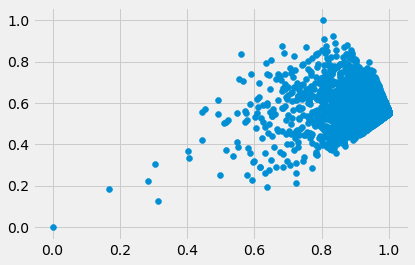

In [144]:
GMM_data = data

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = []
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax
 
# scaled_value = (value - min) / (max - min)
# Calculate min and max for each column
minmax = dataset_minmax(GMM_data)
print(minmax)

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
normalize_dataset(GMM_data, minmax)
print(GMM_data)


x = GMM_data[:,0]
y = GMM_data[:,1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
plt.show()



## Gaussian Mixture Model

### Step 1: How many clusters do we want? K=20
### Step 2: For each data point, calculate the probability that each data point belongs to the cluster C
<img src="formula.JPG">

#### Randomly draw gaussians on the data and see what it returns
#### We want to have 3 gaussian models fitted to our 3 data clusters
<br><font color='green' size="+0.5"><b> How to get 3 gaussians to our data randomly? </b></font><br>
<br><font color='green' size="+0.5"><b> Expectation Maximization algorithm </b></font>


In [146]:
# Random Gaussians
gauss_1 = norm(loc=-5,scale=5)

#  the distribution object can be called (as a function) to fix the shape, location and scale parameters. 
# This returns a “frozen” RV object holding the given parameters fixed.
ax.plot(GMM_data, norm.pdf(GMM_data), 'k-', lw=2, label='frozen pdf')
plt.show()
print("dkcdk")
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)


dkcdk


[ 0  0  7 ... 17  1  1]


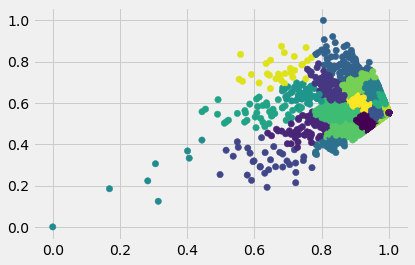

In [147]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=20).fit(GMM_data)
labels = gmm.predict(GMM_data)
print(labels)
plt.scatter(GMM_data[:, 0], GMM_data[:, 1], c=labels, s=40, cmap = 'viridis');

In [149]:
# Create a trace
import plotly
init_notebook_mode(connected=True)

#py.tools.set_credentials_file(username='manviagarwal', api_key='Pesu@123')

trace = go.Scatter(
    x=GMM_data[:,0], 
    y=GMM_data[:,1],
    mode='markers',
    name='Lines, Markers and Text',
    text = new,
    textposition='top',
    marker=dict(
        color = labels,
        colorscale='Portland',
        showscale=True
    )
)

dataL = [trace]
# layout = go.Layout(
    
# )
layout = go.Layout(
    autosize=True,
    showlegend=False
)

fig = go.Figure(data=dataL, layout=layout)

plotly.offline.plot(dataL,filename='Final cluster plot Gaussian Model.html',auto_open=True)




'file://C:\\Users\\maanv\\OneDrive\\Desktop\\Fall 2018\\ML\\Datasets\\Final cluster plot Gaussian Model.html'

In [52]:
# Based on cluster proximity
# MIN , MAX AND GROUP AVERAGE
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [53]:
# generate the linkage matrix
Z = linkage(data, 'ward')

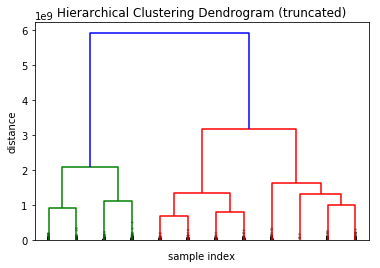

In [54]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

### Normalization and scaling the data

[[0.0, 1.0], [0.0, 1.0]]
[[0.94704 0.50994]
 [0.93135 0.48524]
 [0.82421 0.37871]
 ...
 [0.9947  0.55596]
 [0.99998 0.55282]
 [0.99996 0.55281]]


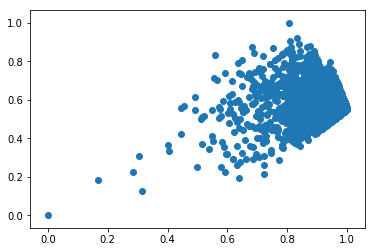

In [112]:
GMM_data = data

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = []
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax
 
# scaled_value = (value - min) / (max - min)
# Calculate min and max for each column
minmax = dataset_minmax(GMM_data)
print(minmax)

def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
normalize_dataset(GMM_data, minmax)
print(GMM_data)


x = GMM_data[:,0]
y = GMM_data[:,1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
plt.show()



In [113]:
from scipy.stats import multivariate_normal

K = 3 # number of clusters
prob = np.zeros((len(GMM_data),K)) # len(data) * number of clusters
print('Dimensionality','=',np.shape(r))

#Get random Gaussians
gauss_1 = norm(loc=0.9,scale=1) 
gauss_2 = norm(loc=0.6,scale=2)
gauss_3 = norm(loc=0.3,scale=1.5)

print(gauss_1)

('Dimensionality', '=', (6820L, 3L))


In [114]:
print(zip(range(3),[gauss_1,gauss_2,gauss_3]))

[(0, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003CE9DC18>), (1, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000003CE9D358>), (2, <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000008ED7048>)]


In [119]:
# Compute the probability that each data point belongs to a gaussian g
# Here we will make a matrix
# The matrix is called prob which we initialized before of size #dataPoints x number of clusters = 3
# Each matrix value gives the probability of each data point belonging to the cluster i
#print(GMM_data)
for col,gauss in zip(range(3),[gauss_1,gauss_2,gauss_3]):
    # Here write the probability that x belongs to gaussian 1/2/3 in column 1/2/3. 
    #print(gauss.pdf(GMM_data) )
    
    # Take the prodeuct of the probabilites of x and y
    prob[:,col] = np.prod(gauss.pdf(GMM_data), axis=1)
    
    # Now we get a 6820 by 3 array with the probability that each point belongs to one of the gaussians


In [129]:

# Normalizing the probability such that each sum = 1
for i in range(len(prob)):
    prob[i] = prob[i]/np.sum(prob,axis=1)[i]
print(prob)
print(np.sum(prob,axis=1))

[[0.5886  0.15642 0.25498]
 [0.58528 0.15711 0.25761]
 [0.5671  0.16087 0.27203]
 ...
 [0.59503 0.15544 0.24952]
 [0.59489 0.15557 0.24954]
 [0.59489 0.15557 0.24954]]
[1. 1. 1. ... 1. 1. 1.]


### So far we have the probilities of each point corresponding to the each gaussian model

In [124]:
# Now we want the likelihood probabilities

In [137]:
# Random pi_c
from __future__ import division
pi = np.array([1/3,1/3,1/3]) # We expect to have three clusters 
print(pi)
prob_new = np.zeros((len(GMM_data),K)) # len(data) * number of clusters

# Probability that each data point belongs to gaussian g
for col,gauss,pic in zip(range(3),[gauss_1,gauss_2,gauss_3],pi):
    prob_new[:,col] = pic*np.prod(gauss.pdf(GMM_data), axis=1) 
print(prob_new)

[0.33333 0.33333 0.33333]
[[0.04911 0.01305 0.02127]
 [0.04866 0.01306 0.02142]
 [0.04618 0.0131  0.02215]
 ...
 [0.04978 0.013   0.02087]
 [0.0497  0.013   0.02085]
 [0.0497  0.013   0.02085]]


In [139]:
# Normalize the probabilities such that each row of r sums to 1 and weight it by pi_c == the fraction of points belonging to 
#cluster c
for i in range(len(prob_new)):
    prob_new[i] = prob_new[i]/(np.sum(pi)*np.sum(prob_new,axis=1)[i])
print(np.sum(prob_new,axis=1))

[1. 1. 1. ... 1. 1. 1.]


0.9470420031358244


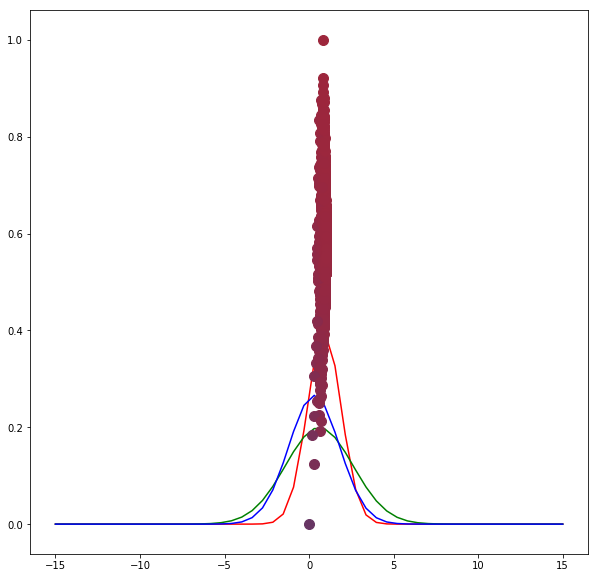

In [141]:
"""Plot the data"""
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.scatter(GMM_data[:,0],GMM_data[:,1])
fig = plt.figure()
for i in range(len(prob_new)):
    
    ax0.scatter(GMM_data[i][0],GMM_data[i][1],c=np.array([prob_new[i][0],prob_new[i][1],prob_new[i][2]]),s=100) 
    # We have defined the first column as red, the second as
                                                                        # green and the third as blue
for g,c in zip([gauss_1.pdf(np.linspace(-15,15)),gauss_2.pdf(np.linspace(-15,15)),gauss_3.pdf(np.linspace(-15,15))],['r','g','b']):
    ax0.plot(np.linspace(-15,15),g,c=c,zorder=0)
    
    
plt.show()